In [2]:
import pandas as pd
import json
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import AutoTokenizer, DataCollatorWithPadding
import numpy as np
import evaluate
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

print(torch.has_mps)
device = torch.device('mps')

/Users/melinaplakidis/Documents/Sprachtechnologie_HA/env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True


In [4]:
### LOAD DATA 

with open("/Users/melinaplakidis/Documents/Sprachtechnologie_HA/data/annotations_with_text.json", "r", encoding="utf8") as f:
    data = json.load(f)

def sentence_iterator(data):
    for ele in data:
        name = ele
        tweet = data[ele]
        for value in tweet.values():
            sentences = value['sentences']
            for sentence in sentences:
                text = sentences[sentence]['text']
                stype = sentences[sentence]['stype']
                if sentences[sentence]['coarse'] == "COMMISSIVE" or sentences[sentence]['coarse'] == "OTHER":
                    coarse = "COMOTH"
                else:
                    coarse = sentences[sentence]['coarse']
                fine = sentences[sentence]['fine']
                yield text, coarse, fine

texts, coarses, fines = [], [], []
for text, coarse, fine in sentence_iterator(data):
    texts.append(text)
    coarses.append(coarse)
    fines.append(fine)
  
df = pd.DataFrame({"text": texts, "coarses": coarses})

In [5]:
#### CONVERT TO HF DATASET

train_df, test_df = train_test_split(df, test_size=0.2, random_state=200)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
print(test_dataset)

Dataset({
    features: ['text', 'coarses', '__index_level_0__'],
    num_rows: 385
})


In [6]:
### START PREPROCESSING 

labels = [i for i in df['coarses'].values.tolist()]
unique_labels = set()

for lb in labels:
    if lb not in unique_labels:
        unique_labels.add(lb)
labels_to_ids = {k: v for v, k in enumerate(sorted(unique_labels))}
ids_to_labels = {v: k for v, k in enumerate(sorted(unique_labels))}


In [8]:
### Coarse (5) uncased is the best performing model

def get_predictions(model_path):
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    predictions = []
    for text in tqdm(test_df["text"]):
        inputs = tokenizer(text, return_tensors="pt").to(device)
        model = AutoModelForSequenceClassification.from_pretrained(model_path, local_files_only=True).to(device)
        with torch.no_grad():
            logits = model(**inputs).logits
        predicted_class_id = logits.argmax().item()
        predicted_label = model.config.id2label[predicted_class_id]
        predictions.append(predicted_label)
    df_results = pd.DataFrame({"Text": test_df["text"], "True Label": test_df["coarses"], "Prediction": predictions})
    texts, labels, predictions = [], [], []
    for text, label, prediction in zip(df_results["Text"], df_results["True Label"], df_results["Prediction"]):
        if label == prediction:
            continue
        else:
            texts.append(text)
            labels.append(label)
            predictions.append(prediction)
    errors = pd.DataFrame({"Text": texts, "True Label": labels, "Prediction": predictions})    
    print(errors)
    return errors

df_results = get_predictions("/Users/melinaplakidis/Documents/Sprachtechnologie_HA/models/coarse_cased_5classes/BESTcheckpoint-485")

100%|██████████| 385/385 [04:49<00:00,  1.33it/s]

                                                 Text  True Label  Prediction
0   Ich hätte auch gerne ne SUpiDupi Friedliche Welt.  EXPRESSIVE   ASSERTIVE
1   #Tagesschau bejubelt #Katar &amp; sein #Islami...   ASSERTIVE  EXPRESSIVE
2             Das ist das Geschenk von Merkel und Co.  EXPRESSIVE   ASSERTIVE
3   Ich will dieses Arschloch nicht auf freiem Fuß...  EXPRESSIVE   ASSERTIVE
4   Hat uns alles IM Erika mitsamt der abgefuckten...      UNSURE   ASSERTIVE
..                                                ...         ...         ...
83  Ich würde ihnen gern eine arte Doku zum Thema ...   ASSERTIVE   DIRECTIVE
84       Dass man ihn noch ins Spital bringt hat was.      UNSURE   ASSERTIVE
85                 Sie wollen besser behandelt werden   ASSERTIVE   DIRECTIVE
86                              Nette Zusammenfassung      UNSURE  EXPRESSIVE
87                                           Beifall.  EXPRESSIVE   ASSERTIVE

[88 rows x 3 columns]


In [9]:
df_results.to_csv("error_analysis.csv")
cm = confusion_matrix(df_results["True Label"], df_results["Prediction"])

In [11]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(sorted(unique_labels)))

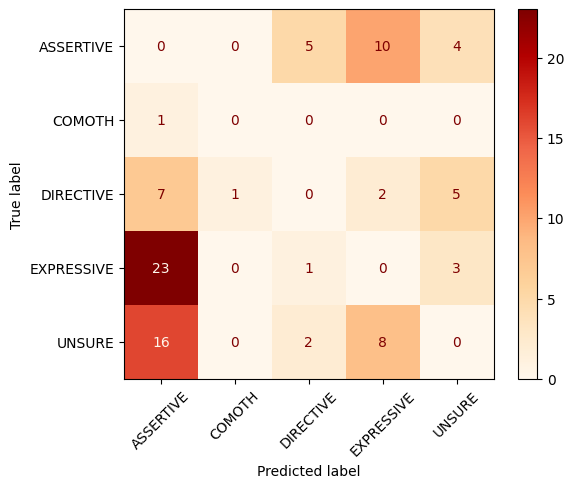

In [15]:
disp.plot(cmap = "OrRd", xticks_rotation=45)
plt.show()